<center><a href="https://www.pieriantraining.com/" ><img src="../PTCenteredPurple.png" alt="Pierian Training Logo" /></a></center>


# Knowledge Retrieval - Single File with Code-Interpreter

Let's explore how to use the code interpreter in conjunction with a Knowledge Base.

In [5]:
from openai import OpenAI

In [6]:
client = OpenAI()

In [7]:
# Make sure you are using at least version 1.3.8 to be able to grab image files!
#!pip install openai --upgrade
import openai
print(openai.__version__)
assert(openai.__version__ == '1.3.8')

1.3.8


----

## Uploading Files

In [8]:
files_to_upload = ['SP500_Prices_5Year.csv']

In [9]:
def upload_assistant_file(filename):
    file = client.files.create(
      file=open(filename, "rb"),
      purpose='assistants'
    )
    print(file.id)

In [10]:
for file in files_to_upload:
    upload_assistant_file(file)

file-EypREgCjASakrMOWH8YUKL8T


In [11]:
for file in client.files.list():
    print(f"{file.filename} has id of: {file.id}")

SP500_Prices_5Year.csv has id of: file-EypREgCjASakrMOWH8YUKL8T


## Create Assistant

In [13]:
# Add the file to the assistant
assistant = client.beta.assistants.create(
    name='Stock Visualizer',
  instructions="You use code and files to help visualize stock data.",
  model="gpt-3.5-turbo-1106", # CHECK FOR ERROR IF YOU PROVIDE THE WRONG MODEL
  tools=[{"type": "retrieval"},{'type':'code_interpreter'}])

## Run a Thread and Add a File to Message

When a file is attached at the Message-level, it is only accessible within the specific Thread the Message is attached to. After having uploaded a file, you can pass the ID of this File when creating the Message. Note that you are not charged based on the size of the files you upload via the Files API but rather based on which files you attach to a specific Assistant or Message that get indexed.

In [14]:
thread = client.beta.threads.create()

In [15]:
file.id

'file-EypREgCjASakrMOWH8YUKL8T'

In [16]:
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Can you create a plot of the historical Adjusted Closing price of the SP500?",
    file_ids=[file.id],
)

In [17]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions = f"Use file with if: {file.id} to answer questions." # This helps to force the model to access the file!
)

In [18]:
run.status

'queued'

In [20]:
# NOTE: Using files and code-interpreter will likely take longer, the assistant needs to run the code!
run = client.beta.threads.runs.retrieve(
          thread_id=thread.id,
          run_id=run.id
        )
    
print(run.status)

completed


Once the run is completed, let's get the messages

In [21]:
messages = client.beta.threads.messages.list(
    thread_id=thread.id, order="asc",
)

## Assistant Returning Files

Note that we asked for a plot, that meands the messages likely contain more than just text!

In [22]:
messages

SyncCursorPage[ThreadMessage](data=[ThreadMessage(id='msg_JvZLTL2T0qbpObNRDnizcf5M', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='Can you create a plot of the historical Adjusted Closing price of the SP500?'), type='text')], created_at=1702248410, file_ids=['file-EypREgCjASakrMOWH8YUKL8T'], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_ESKO1UubqInNMdtoKhrNGtv6'), ThreadMessage(id='msg_vXIDOMpYhyDp1v8th5A3HZbx', assistant_id='asst_XKWhGGdL8AKVnDDAn18M1ndq', content=[MessageContentText(text=Text(annotations=[], value='I will start by loading the data from the file to examine its structure and contents.'), type='text')], created_at=1702248412, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_BHyK4Plw9PEIWhsnCRsXtUPx', thread_id='thread_ESKO1UubqInNMdtoKhrNGtv6'), ThreadMessage(id='msg_96BYL9VFA8A83NmWq57zKKEQ', assistant_id='asst_XKWhGGdL8AKVnDDAn18M1ndq', content=[MessageContentText(tex

In [23]:
for thread_message in messages:
    print(thread_message)
    print('\n')

ThreadMessage(id='msg_JvZLTL2T0qbpObNRDnizcf5M', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='Can you create a plot of the historical Adjusted Closing price of the SP500?'), type='text')], created_at=1702248410, file_ids=['file-EypREgCjASakrMOWH8YUKL8T'], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_ESKO1UubqInNMdtoKhrNGtv6')


ThreadMessage(id='msg_vXIDOMpYhyDp1v8th5A3HZbx', assistant_id='asst_XKWhGGdL8AKVnDDAn18M1ndq', content=[MessageContentText(text=Text(annotations=[], value='I will start by loading the data from the file to examine its structure and contents.'), type='text')], created_at=1702248412, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_BHyK4Plw9PEIWhsnCRsXtUPx', thread_id='thread_ESKO1UubqInNMdtoKhrNGtv6')


ThreadMessage(id='msg_96BYL9VFA8A83NmWq57zKKEQ', assistant_id='asst_XKWhGGdL8AKVnDDAn18M1ndq', content=[MessageContentText(text=Text(annotations=[], value="The 

In [24]:
# GRAB ONLY THAT LAST MESSAGE WITH THE IMAGE
# ALTERNATIVELY USE after parameter when listing messages to only grab last message
message = client.beta.threads.messages.retrieve(
  message_id='msg_xkltbAGWhb7Hz9NcD5kZMiKl',
  thread_id='thread_ESKO1UubqInNMdtoKhrNGtv6',
)

In [25]:
message

ThreadMessage(id='msg_xkltbAGWhb7Hz9NcD5kZMiKl', assistant_id='asst_XKWhGGdL8AKVnDDAn18M1ndq', content=[MessageContentImageFile(image_file=ImageFile(file_id='file-2OVV0l92vOGYXsGHwH6fpMU6'), type='image_file'), MessageContentText(text=Text(annotations=[], value='The plot above shows the historical adjusted closing price of the S&P 500. The x-axis represents the date, and the y-axis represents the adjusted closing price.'), type='text')], created_at=1702248423, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_BHyK4Plw9PEIWhsnCRsXtUPx', thread_id='thread_ESKO1UubqInNMdtoKhrNGtv6')

In [26]:
message.content

[MessageContentImageFile(image_file=ImageFile(file_id='file-2OVV0l92vOGYXsGHwH6fpMU6'), type='image_file'),
 MessageContentText(text=Text(annotations=[], value='The plot above shows the historical adjusted closing price of the S&P 500. The x-axis represents the date, and the y-axis represents the adjusted closing price.'), type='text')]

In [27]:
message.content[1].text.value

'The plot above shows the historical adjusted closing price of the S&P 500. The x-axis represents the date, and the y-axis represents the adjusted closing price.'

But we need to grab the image! We can save it and display it

In [28]:
message.content[0].image_file.file_id

'file-2OVV0l92vOGYXsGHwH6fpMU6'

In [29]:
image = client.files.content('file-HkLOUJgNiEUGfqJzhBBhJIHO')
# I got a warning here, but the official docs and migration guide to state to use .retrieve_content so who knows?

In [33]:
# image.content

In [34]:
# Write the bytes to a file
with open('image.png', 'wb') as file:
    file.write(image.content)


## Optional: Display Image inside Notebook:

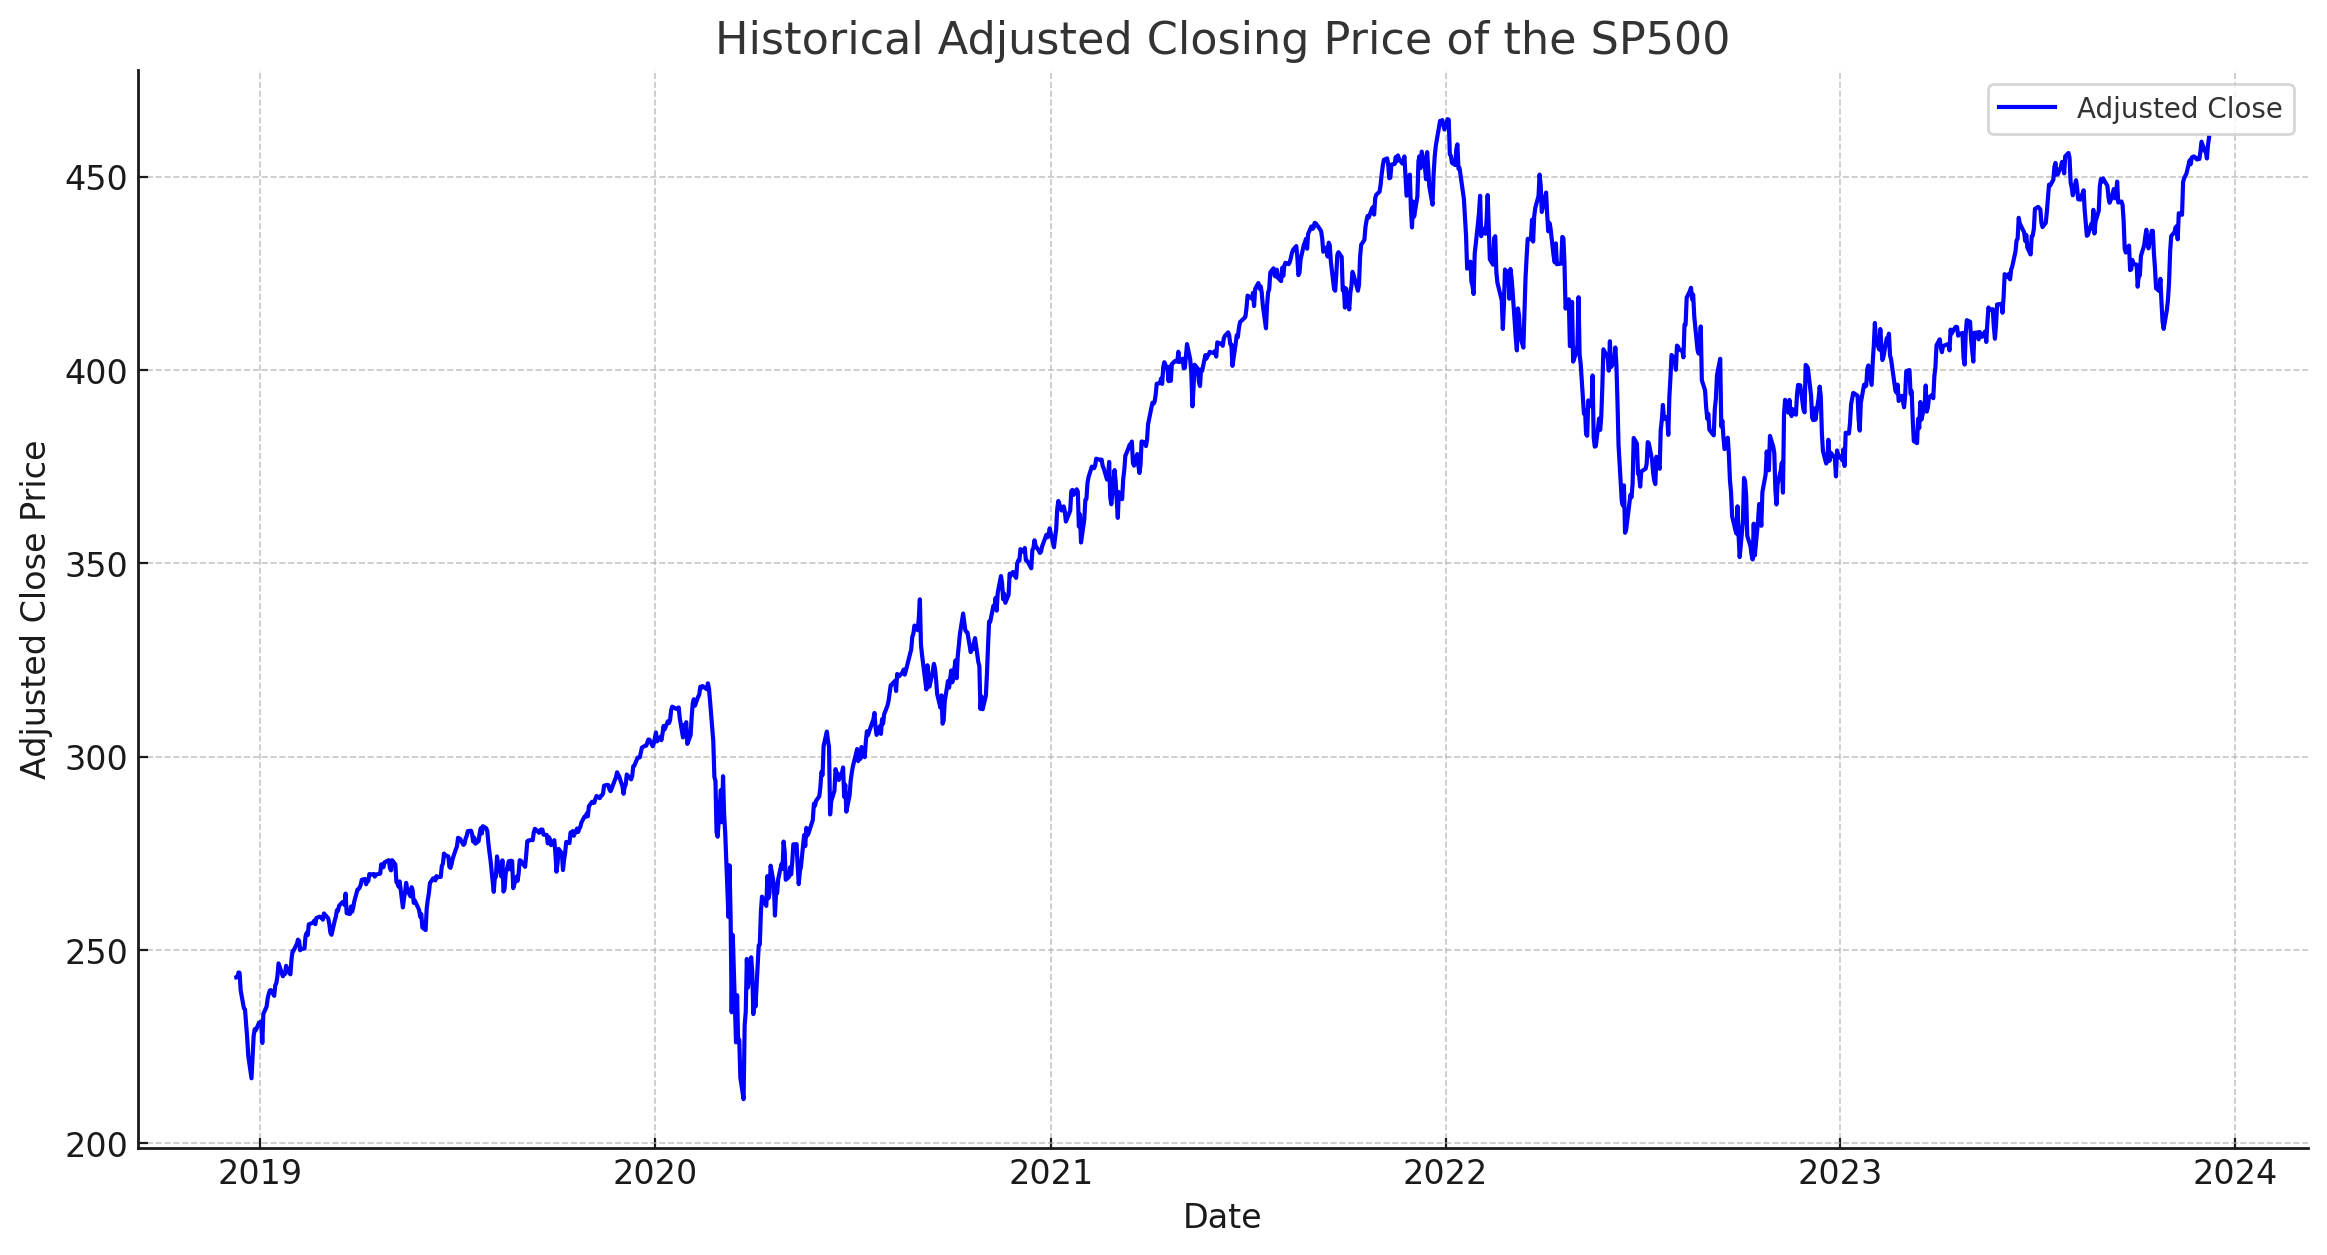

In [35]:
from IPython.display import Image

# Display the image
Image(filename='image.png')


# Optional: Delete Assistant and All Files

In [36]:
my_assistants = client.beta.assistants.list(
    order="desc",
    limit="20",
)
response = client.beta.assistants.delete(my_assistants.data[0].id)
print(response)

AssistantDeleted(id='asst_XKWhGGdL8AKVnDDAn18M1ndq', deleted=True, object='assistant.deleted')


In [37]:
for file in client.files.list():
    client.files.delete(file.id)

In [38]:
client.files.list()

SyncPage[FileObject](data=[], object='list', has_more=False)